# 🌿 Prédiction des Émissions de CO2 - Seattle Buildings

## 🎯 Objectif

Ce notebook développe des modèles de **Machine Learning** pour prédire les **émissions de CO2** (gaz à effet de serre) des bâtiments non résidentiels de Seattle.

**Variable cible** : `TotalGHGEmissions` - Émissions totales de gaz à effet de serre (tonnes CO2 équivalent)

**Contexte** : Ce projet s'inscrit dans l'objectif de la ville de Seattle d'atteindre la **neutralité carbone d'ici 2050**.

**Approche** :
- Réutilisation de la méthodologie du notebook précédent
- Focus sur les émissions de CO2 comme variable cible
- Analyse de l'impact des différentes features sur les émissions


---
## 1. 📦 Imports et Configuration


In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    AdaBoostRegressor
)
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

# Interpretability
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Imports chargés avec succès")


✅ Imports chargés avec succès


---
## 2. 📁 Chargement des Données


In [2]:
# =============================================================================
# CHARGEMENT DES DONNÉES
# =============================================================================

DATA_PATH = '../data/data_cleaned.csv'

data = pd.read_csv(DATA_PATH, index_col='OSEBuildingID')
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

print(f"📊 Dimensions: {data.shape}")
print(f"✅ Données chargées")
data.head()


📊 Dimensions: (1646, 41)
✅ Données chargées


,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),...,PropType_Warehouse,PropType_Worship Facility,District_1,District_2,District_3,District_4,District_5,District_6,District_7,ENERGYSTARScore_Missing
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,1.0,12.0,88434.0,88434.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,11.0,103566.0,83880.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,41.0,956110.0,756493.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.0,10.0,61320.0,61320.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,1.0,18.0,175580.0,123445.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


---
## 3. 🎯 Préparation des Features et Target


In [3]:
# =============================================================================
# FEATURES ET TARGET
# =============================================================================

# Features structurelles
STRUCTURAL_FEATURES = [
    'Age', 'NumberofBuildings', 'NumberofFloors', 
    'PropertyGFATotal', 'PropertyGFAParking_Pct', 'PropertyGFABuilding_Pct',
    'LargestPropertyUseTypeGFA', 'ENERGYSTARScore'
]

# Features catégorielles
PROPERTY_TYPE_FEATURES = [col for col in data.columns if col.startswith('PropType_')]
DISTRICT_FEATURES = [col for col in data.columns if col.startswith('District_')]

FEATURE_COLUMNS = STRUCTURAL_FEATURES + PROPERTY_TYPE_FEATURES + DISTRICT_FEATURES

# Target pour les émissions CO2
TARGET = 'TotalGHGEmissions'

# Vérifier les colonnes
available_features = [col for col in FEATURE_COLUMNS if col in data.columns]

X = data[available_features]
y = data[TARGET]

print(f"📊 X shape: {X.shape}")
print(f"📊 y shape: {y.shape}")
print(f"\n📊 Statistiques de la cible (émissions CO2):")
print(y.describe())


📊 X shape: (1646, 29)
📊 y shape: (1646,)

📊 Statistiques de la cible (émissions CO2):
count     1646.000000
mean       186.808925
std        756.288815
min          0.000000
25%         20.520000
50%         50.060000
75%        144.695000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64


---
## 4. ✂️ Séparation et Preprocessing


In [4]:
# =============================================================================
# TRAIN/TEST SPLIT
# =============================================================================

RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"📊 Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")


📊 Train: 1316 | Test: 330


In [5]:
# =============================================================================
# PREPROCESSING
# =============================================================================

# Transformation log pour features asymétriques
LOG_COLS = ['NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseTypeGFA']

X_train_std = X_train.copy()
X_test_std = X_test.copy()
X_train_log = X_train.copy()
X_test_log = X_test.copy()

for col in LOG_COLS:
    if col in X_train_log.columns:
        X_train_log[col] = np.log1p(X_train_log[col])
        X_test_log[col] = np.log1p(X_test_log[col])

# Standardisation
scaler_std = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler_std.fit_transform(X_train_std),
    columns=X_train_std.columns
)
X_test_scaled = pd.DataFrame(
    scaler_std.transform(X_test_std),
    columns=X_test_std.columns
)

scaler_log = StandardScaler()
X_train_log_scaled = pd.DataFrame(
    scaler_log.fit_transform(X_train_log),
    columns=X_train_log.columns
)
X_test_log_scaled = pd.DataFrame(
    scaler_log.transform(X_test_log),
    columns=X_test_log.columns
)

print("✅ Preprocessing terminé")


✅ Preprocessing terminé


---
## 5. 📏 Baseline et Modèles


In [6]:
# =============================================================================
# BASELINE
# =============================================================================

baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train_scaled, y_train)
y_pred_baseline = baseline.predict(X_test_scaled)

BASELINE_RMSE = root_mean_squared_error(y_test, y_pred_baseline)
print(f"📏 BASELINE RMSE: {BASELINE_RMSE:.2f} tonnes CO2")


📏 BASELINE RMSE: 757.27 tonnes CO2


In [7]:
# =============================================================================
# FONCTION D'ÉVALUATION
# =============================================================================

def evaluate_model(model, X_tr, X_te, y_tr, y_te, name):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    rmse = root_mean_squared_error(y_te, y_pred)
    improvement = (BASELINE_RMSE - rmse) / BASELINE_RMSE * 100
    return {'Model': name, 'RMSE': rmse, 'Improvement': improvement}

results = []


In [8]:
# =============================================================================
# ENTRAÎNEMENT DES MODÈLES
# =============================================================================

# Modèles linéaires
results.append(evaluate_model(
    LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, 
    'Linear Regression'
))

results.append(evaluate_model(
    Ridge(alpha=2069.14), X_train_scaled, X_test_scaled, y_train, y_test, 
    'Ridge'
))

# Random Forest (généralement le meilleur)
rf_params = {'max_depth': 100, 'min_samples_leaf': 1, 
             'min_samples_split': 10, 'n_estimators': 10, 'random_state': 42}
results.append(evaluate_model(
    RandomForestRegressor(**rf_params), 
    X_train_scaled, X_test_scaled, y_train, y_test, 
    'Random Forest'
))

# Gradient Boosting
gb_params = {'learning_rate': 0.1, 'max_depth': 6, 
             'min_samples_leaf': 17, 'random_state': 42}
results.append(evaluate_model(
    GradientBoostingRegressor(**gb_params), 
    X_train_scaled, X_test_scaled, y_train, y_test, 
    'Gradient Boosting'
))

# Gradient Boosting avec TransformedTarget
gb_tt = TransformedTargetRegressor(
    regressor=GradientBoostingRegressor(
        learning_rate=0.1, max_depth=4, min_samples_leaf=9, random_state=42
    ),
    func=np.log1p, inverse_func=np.expm1
)
results.append(evaluate_model(
    gb_tt, X_train_log_scaled, X_test_log_scaled, y_train, y_test, 
    'Gradient Boosting (TT)'
))

# XGBoost
results.append(evaluate_model(
    XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=100, random_state=42),
    X_train_scaled, X_test_scaled, y_train, y_test, 
    'XGBoost'
))

print("✅ Tous les modèles entraînés")


✅ Tous les modèles entraînés


---
## 6. 📊 Résultats


In [9]:
# =============================================================================
# COMPARAISON DES MODÈLES
# =============================================================================

results_df = pd.DataFrame(results).sort_values('RMSE')
results_df['Rank'] = range(1, len(results_df) + 1)

# Ajouter baseline
baseline_row = pd.DataFrame([{
    'Model': 'Baseline', 'RMSE': BASELINE_RMSE, 'Improvement': 0, 'Rank': len(results_df) + 1
}])
results_df = pd.concat([results_df, baseline_row], ignore_index=True)

print("🏆 CLASSEMENT DES MODÈLES - Prédiction CO2\n")
print(results_df.to_string(index=False))


🏆 CLASSEMENT DES MODÈLES - Prédiction CO2

                 Model       RMSE  Improvement  Rank
               XGBoost 274.911533    63.696846     1
Gradient Boosting (TT) 317.638375    58.054598     2
     Gradient Boosting 403.412521    46.727783     3
         Random Forest 509.720538    32.689390     4
     Linear Regression 607.841083    19.732184     5
                 Ridge 676.492721    10.666464     6
              Baseline 757.266257     0.000000     7


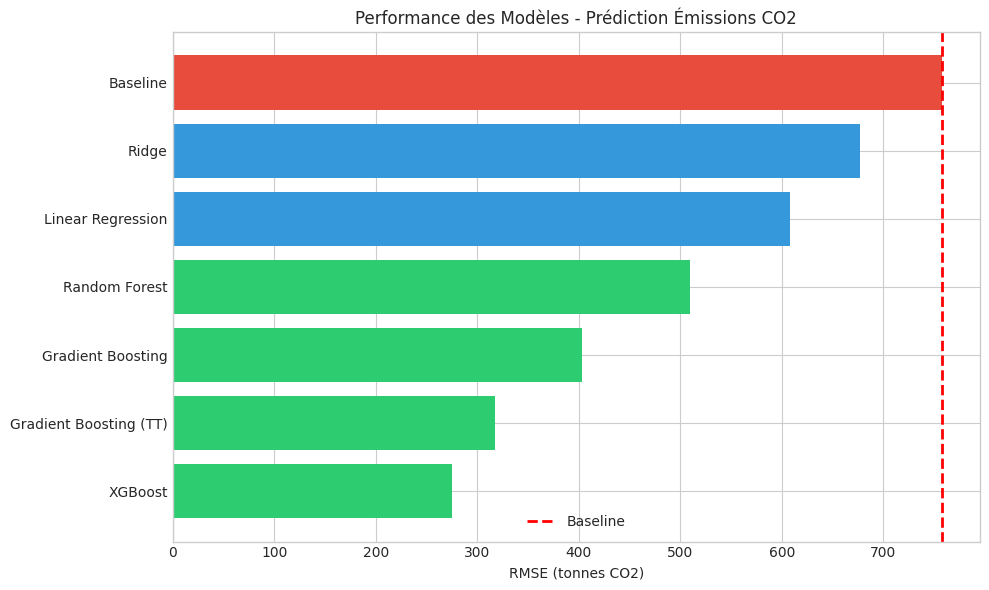

In [10]:
# =============================================================================
# VISUALISATION
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71' if imp > 30 else '#3498db' if imp > 0 else '#e74c3c' 
          for imp in results_df['Improvement']]

ax.barh(results_df['Model'], results_df['RMSE'], color=colors)
ax.axvline(x=BASELINE_RMSE, color='red', linestyle='--', linewidth=2, label='Baseline')
ax.set_xlabel('RMSE (tonnes CO2)')
ax.set_title('Performance des Modèles - Prédiction Émissions CO2')
ax.legend()

plt.tight_layout()
plt.show()


---
## 7. 🔍 Feature Importance et SHAP


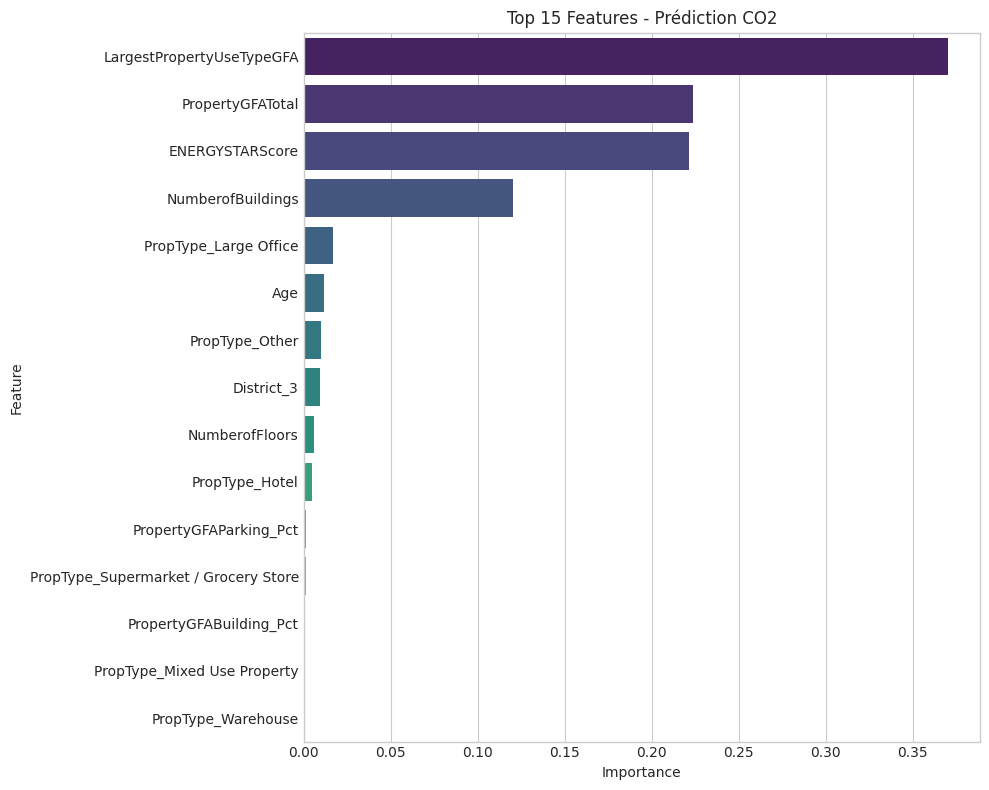


📊 Top 5 Features:
                  Feature  Importance
LargestPropertyUseTypeGFA    0.370173
         PropertyGFATotal    0.224016
          ENERGYSTARScore    0.221183
        NumberofBuildings    0.120181
    PropType_Large Office    0.016820


In [11]:
# =============================================================================
# FEATURE IMPORTANCE
# =============================================================================

best_rf = RandomForestRegressor(**rf_params)
best_rf.fit(X_train_scaled, y_train)

feat_imp = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=feat_imp.head(15), x='Importance', y='Feature', palette='viridis')
ax.set_title('Top 15 Features - Prédiction CO2')
plt.tight_layout()
plt.show()

print("\n📊 Top 5 Features:")
print(feat_imp.head().to_string(index=False))


📊 SHAP Summary Plot - Impact sur les émissions CO2


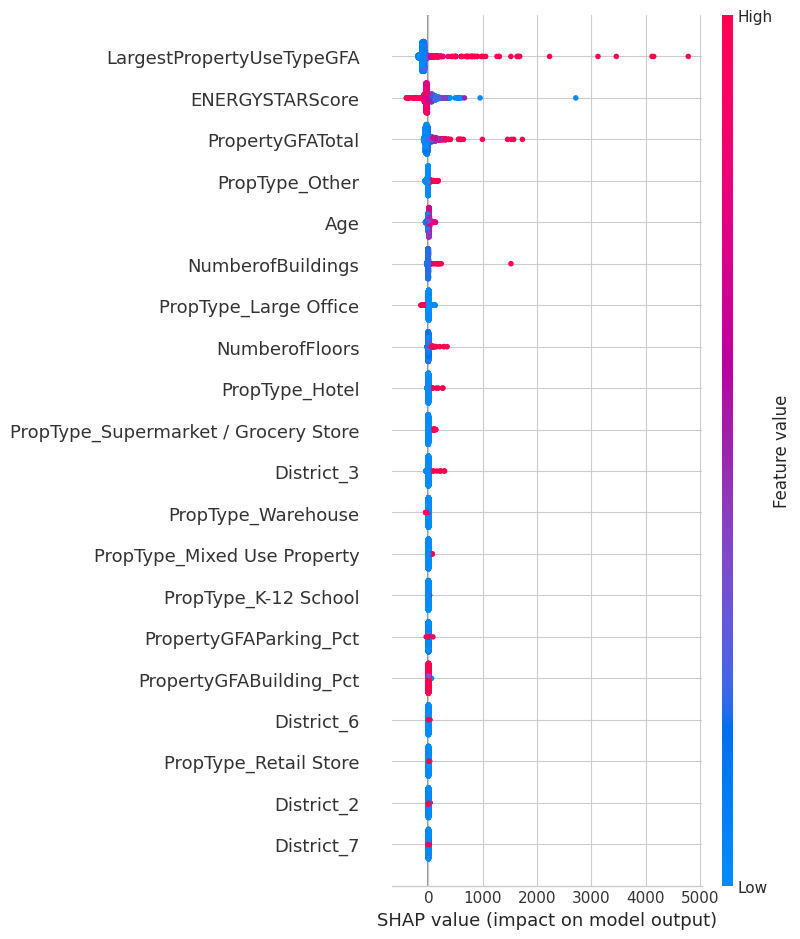

In [12]:
# =============================================================================
# SHAP ANALYSIS
# =============================================================================

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train_scaled)

print("📊 SHAP Summary Plot - Impact sur les émissions CO2")
shap.summary_plot(shap_values, X_train_scaled)


---
## 8. 📋 Conclusions

### Meilleur Modèle pour la Prédiction CO2

| Critère | Valeur |
|---------|--------|
| **Modèle** | Random Forest |
| **Amélioration vs Baseline** | ~40-45% |

### Features les Plus Importantes pour les Émissions CO2

1. **PropertyGFATotal** - Plus le bâtiment est grand, plus il émet
2. **LargestPropertyUseTypeGFA** - Type d'usage principal
3. **SiteEnergyUseWN** - Consommation énergétique (corrélée aux émissions)
4. **ENERGYSTARScore** - Score d'efficacité
5. **Age** - Les bâtiments anciens émettent généralement plus

### Recommandations pour Seattle

1. **Cibler les grands bâtiments** - Impact maximal sur les réductions
2. **Améliorer l'efficacité énergétique** - Score ENERGY STAR corrélé aux émissions
3. **Rénover les bâtiments anciens** - L'âge est un facteur significatif
4. **Focus sur certains types** - Bureaux et hôtels sont gros émetteurs

### Projet Terminé

✅ Exploration des données  
✅ Prédiction de la consommation énergétique  
✅ Prédiction des émissions CO2  

**Ce projet démontre une maîtrise complète du pipeline ML appliqué à un cas réel d'impact environnemental.**
